In [3]:
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib  as mpl
from tqdm import tqdm
import pickle
import lzma
import time
import os

import numpy as np

from DimensionReduction import Grassmann, DiffusionMaps
from GDMaps_PCE_GSA import *


# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [2]:
def plot_dm_parsim_coord(coord, g):
    
    comb1 = list(combinations(list(coord), 2))
    comb2 = list(combinations([i for i in range(coord.shape[0])], 2))

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
        
        for i in range(len(comb1)):
            ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            ax[i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            ax[i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        plt.show()
        
        
def plot_dm_parsim_coord_multi_level(coords, gs):
    
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    
    titles = ["Micro-Level Diffusion Coordinates",
              "Meso-Level Diffusion Coordinates",
              "Global-Level Diffusion Coordinates"]
    
    for k, coord in enumerate(coords):
        comb1 = list(combinations(list(coord), 2))
        comb2 = list(combinations([i for i in range(coord.shape[0])], 2))
        
        g = gs[k]

        for i in range(len(comb1)):
            axs[k][i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            axs[k][i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            axs[k][i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            axs[k][i].grid('True')
            axs[k][i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))  
        
        axs[k][1].set_title(titles[k], fontsize=20, y=1.2)
    
    fig.tight_layout()
    plt.savefig("diffusion_coordinates.pdf", bbox_inches="tight")
    plt.show()


def run_GDMaps(p, 
               data, 
               num_runs=10, 
               n_keep=3, 
               parsim=True):
    
    evals_diff_runs  = []
    evecs_diff_runs  = []
    coord_diff_runs = []
    g_diff_runs = []
    residuals_diff_runs = []
    index_diff_runs = []
    
    for i in range(num_runs):
        print('Run: ', i)
        data_all = data[i]

        # Perform GDMAps
        start_time = time.time()
        
        if parsim:
            g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data_all, 
                                                                     n_evecs=20,
                                                                     n_keep=n_keep,
                                                                     parsim=parsim,
                                                                     p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
            residuals_diff_runs.append(residuals)
            index_diff_runs.append(index)
            
        else:
            g, coord, Grass, evals, evecs = GDMaps(data=data_all, 
                                                   n_evecs=20,
                                                   n_keep=n_keep,
                                                   parsim=parsim,
                                                   p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
        
        print("--- GDMaps - %s seconds ---" % (time.time() - start_time))
    
    return (evals_diff_runs, evecs_diff_runs, coord_diff_runs, g_diff_runs,
            residuals_diff_runs, index_diff_runs)

# Playground

### Micro

In [6]:
DATA = np.zeros((20, 7168, 350, 350), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir("../new_W_arrays/"))):
    data = pickle.load(lzma.open(f"../new_W_arrays/{f}"))
    # drop last time step
    data = data[:,:,:100].reshape(7168, 350, 350)
    DATA[i] = data

20it [14:29, 43.47s/it]


In [7]:
ranks = []
num_runs = 20

for run in tqdm(range(num_runs)):
    data_all = DATA[run].astype(np.float32)
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:20:29<00:00, 241.48s/it]

Ranks: 
 [[   5    4]
 [   6   14]
 [   7   19]
 [   8   25]
 [   9   42]
 [  10   63]
 [  11   87]
 [  12  101]
 [  13  110]
 [  14  126]
 [  15  151]
 [  16  162]
 [  17  178]
 [  18  204]
 [  19  244]
 [  20  242]
 [  21  248]
 [  22  273]
 [  23  272]
 [  24  236]
 [  25  276]
 [  26  281]
 [  27  280]
 [  28  258]
 [  29  313]
 [  30  262]
 [  31  286]
 [  32  276]
 [  33  279]
 [  34  276]
 [  35  276]
 [  36  301]
 [  37  246]
 [  38  257]
 [  39  274]
 [  40  258]
 [  41  247]
 [  42  254]
 [  43  236]
 [  44  236]
 [  45  253]
 [  46  231]
 [  47  282]
 [  48  261]
 [  49  246]
 [  50  258]
 [  51  259]
 [  52  288]
 [  53  272]
 [  54  248]
 [  55  270]
 [  56  284]
 [  57  323]
 [  58  268]
 [  59  265]
 [  60  270]
 [  61  310]
 [  62  295]
 [  63  289]
 [  64  323]
 [  65  319]
 [  66  339]
 [  67  328]
 [  68  302]
 [  69  375]
 [  70  326]
 [  71  359]
 [  72  347]
 [  73  383]
 [  74  366]
 [  75  409]
 [  76  405]
 [  77  392]
 [  78  420]
 [  79  421]
 [  80  406]
 [ 

### Meso

In [ ]:
with open("augmented_communities.pickle", "rb") as f:
    communities = pickle.load(f)
community_keys = sorted(list(communities.keys()))[:-1]

rand_comm_duplicates = list(np.random.choice(community_keys, size=8, replace=False))
community_keys += rand_comm_duplicates

In [ ]:
DATA = np.zeros((10, 8192, 110, 110), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir("./concat_W_arrays_cpt/"))):
    
    data = pickle.load(lzma.open(f"./concat_W_arrays_cpt/{f}"))
    
    # drop some time steps
    data = data[:,:,:44]
    
    community_averages = np.zeros((8192, 275, 44), dtype=np.float16)
    for p_idx, param_item in enumerate(data):
        for k_idx, key in enumerate(community_keys):
            comm_avg = np.mean(param_item[communities[key]], axis=0)
            community_averages[p_idx][k_idx] = comm_avg

    DATA[i] = community_averages.reshape(8192, 110, 110)

In [ ]:
ranks = []
num_runs = 20

for run in tqdm(range(num_runs)):
    data_all = DATA[run].astype(np.float32)
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

### Macro

In [19]:
DATA = np.zeros((20, 7168, 10, 10), dtype=np.float16)
for i,f in tqdm(enumerate(os.listdir("../new_W_arrays/"))):
    data = pickle.load(lzma.open(f"../new_W_arrays/{f}"))
    data = np.mean(data, axis=1)[:,:100].reshape(1, 7168, 10, 10)
    DATA[i] = data

20it [14:35, 43.75s/it]


In [21]:
ranks = []
num_runs = 20

for run in tqdm(range(num_runs)):
    data_all = DATA[run].astype(np.float32)
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.80it/s]

Ranks: 
 [[     1      1]
 [     2   1125]
 [     3  11712]
 [     4   2592]
 [     5    758]
 [     6    473]
 [     7    284]
 [     8    258]
 [     9  11602]
 [    10 114555]]


# Run micro level GDMaps

In [3]:
p_micro = 91
for i,f in enumerate(os.listdir("../new_W_arrays/")):
    seed = int(f.split("_")[0])
    data = pickle.load(lzma.open(f"../new_W_arrays/{f}"))
    data = data[:,:,:100].reshape(1, 7168, 350, 350)
    results = run_GDMaps(p=p_micro, data=data, num_runs=1)
    with open(f"../GDMAPS_results/micro_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

Run:  0
Running with parsimonious representation
--- GDMaps - 15038.691394090652 seconds ---


FileNotFoundError: [Errno 2] No such file or directory: 'GDMAPS_results/micro_11.pickle'

# Run meso level GDMaps

In [ ]:
with open("augmented_communities.pickle", "rb") as f:
    communities = pickle.load(f)
community_keys = sorted(list(communities.keys()))[:-1]

rand_comm_duplicates = list(np.random.choice(community_keys, size=8, replace=False))
community_keys += rand_comm_duplicates

In [ ]:
p_meso = 70

for i,f in enumerate(os.listdir("./concat_W_arrays_cpt/")):
    
    seed = int(f.split("_")[0])
    if seed in [8,0,7]:
        continue
        
    data = pickle.load(lzma.open(f"./concat_W_arrays_cpt/{f}"))
    data = data[:,:,:44]
    
    community_averages = np.zeros((8192, 275, 44), dtype=np.float16)
    for p_idx, param_item in enumerate(data):
        for k_idx, key in enumerate(community_keys):
            comm_avg = np.mean(param_item[communities[key]], axis=0)
            community_averages[p_idx][k_idx] = comm_avg
    
    data = community_averages.reshape(1, 8192, 110, 110)
    
    results = run_GDMaps(p=p_meso, data=data, num_runs=1)
    with open(f"GDMAPS_results/meso_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

# Run macro level GDMaps

In [8]:
p_global = 3

for i,f in tqdm(enumerate(os.listdir("../new_W_arrays/"))):
    seed = int(f.split("_")[0])
    print(seed)
    if f"macro_{seed}.pickle" in os.listdir("../GDMaps_results/"):
        continue
    data = pickle.load(lzma.open(f"../new_W_arrays/{f}"))
    data = np.mean(data, axis=1)[:,:100].reshape(1, 7168, 10, 10)
    results = run_GDMaps(p=p_global, data=data, num_runs=1)
    with open(f"../GDMAPS_results/macro_{seed}.pickle", "wb") as f:
        pickle.dump(results, f)

0it [00:00, ?it/s]

11
19
16
17
18
10
12
15
Run:  0
Running with parsimonious representation


8it [14:55, 111.95s/it]

--- GDMaps - 852.9130711555481 seconds ---
14
Run:  0
Running with parsimonious representation


9it [32:33, 255.30s/it]

--- GDMaps - 1014.3081619739532 seconds ---
13
Run:  0
Running with parsimonious representation


10it [51:28, 411.75s/it]

--- GDMaps - 1089.6900820732117 seconds ---
2
Run:  0
Running with parsimonious representation


11it [1:09:56, 552.87s/it]

--- GDMaps - 1064.9050381183624 seconds ---
5
Run:  0
Running with parsimonious representation


12it [1:27:47, 669.28s/it]

--- GDMaps - 1027.484275817871 seconds ---
4
Run:  0
Running with parsimonious representation


13it [1:44:20, 747.85s/it]

--- GDMaps - 949.0422620773315 seconds ---
3
Run:  0
Running with parsimonious representation


14it [2:02:57, 842.93s/it]

--- GDMaps - 1073.5107872486115 seconds ---
9
Run:  0
Running with parsimonious representation


15it [2:21:46, 919.80s/it]

--- GDMaps - 1086.1128346920013 seconds ---
1
Run:  0
Running with parsimonious representation


16it [2:40:38, 978.88s/it]

--- GDMaps - 1087.9621541500092 seconds ---
6
Run:  0
Running with parsimonious representation


17it [2:58:57, 1012.82s/it]

--- GDMaps - 1054.496421098709 seconds ---
7
Run:  0
Running with parsimonious representation


18it [3:17:29, 1041.55s/it]

--- GDMaps - 1068.7703139781952 seconds ---
0
Run:  0
Running with parsimonious representation


19it [3:36:02, 1062.54s/it]

--- GDMaps - 1068.8961489200592 seconds ---
8
Run:  0
Running with parsimonious representation


20it [3:54:23, 703.20s/it] 

--- GDMaps - 1057.1955089569092 seconds ---


# Plot results

In [13]:
# fig, axs = plt.subplots(3,3)

seed = 0

coords = []
gs = []


for i,path in enumerate([f"../GDMaps_results/macro_{seed}.pickle"]):
    
    with open("../GDMAPS_results/" + path, "rb") as f:
        evals, evecs_diff_runs, coord, g_diff_runs, \
            residuals_diff_runs, index_diff_runs = pickle.load(f)
    
    coords.append(coord[0])
    gs.append(g_diff_runs[0])

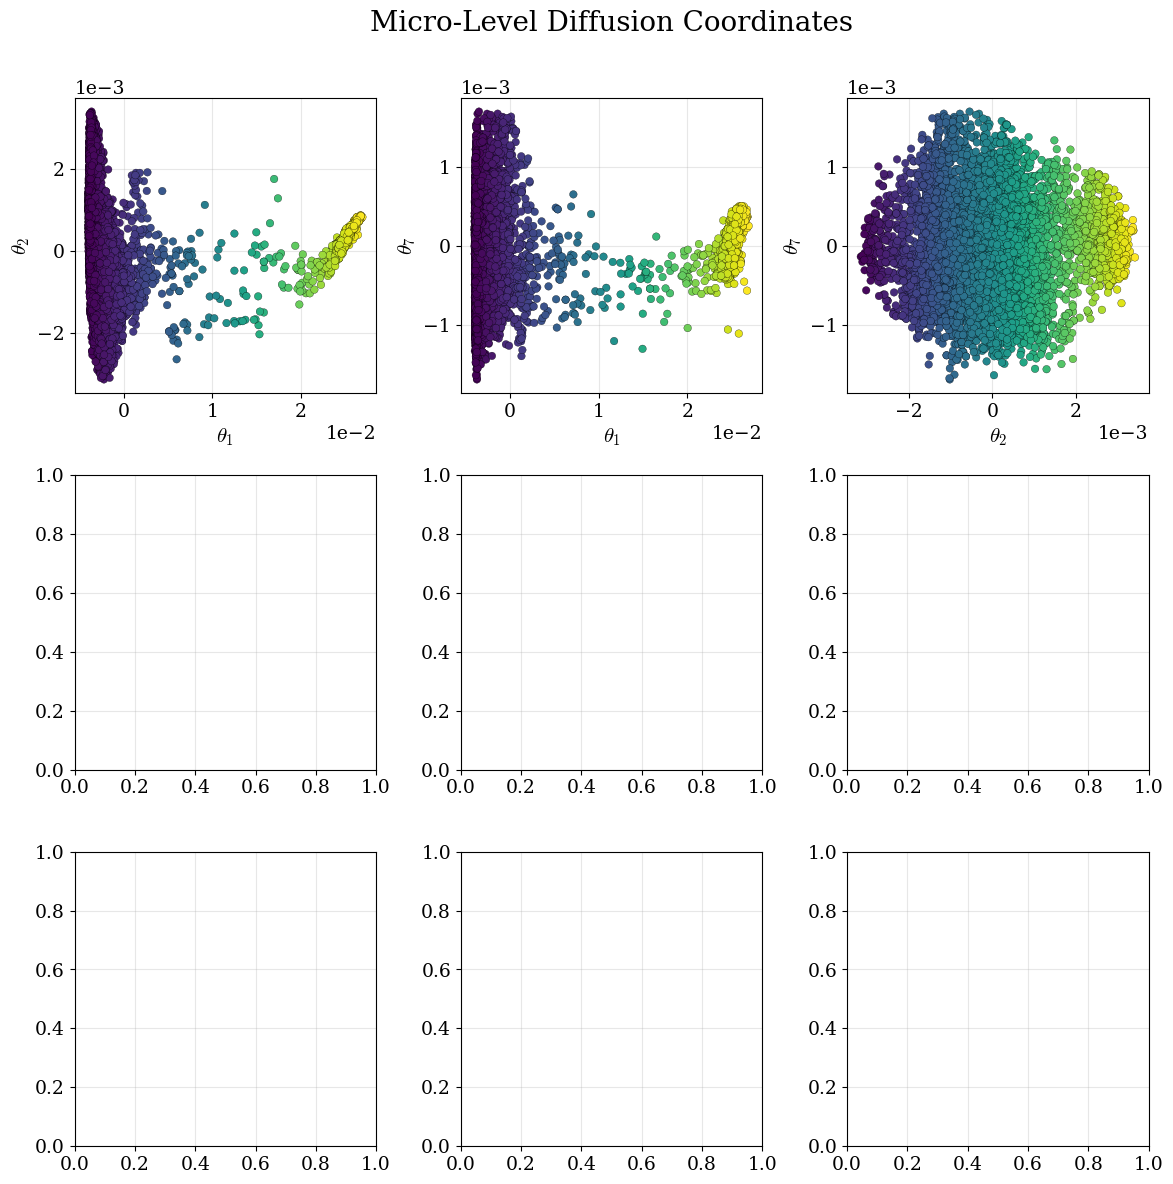

In [14]:
plot_dm_parsim_coord_multi_level(coords, gs)

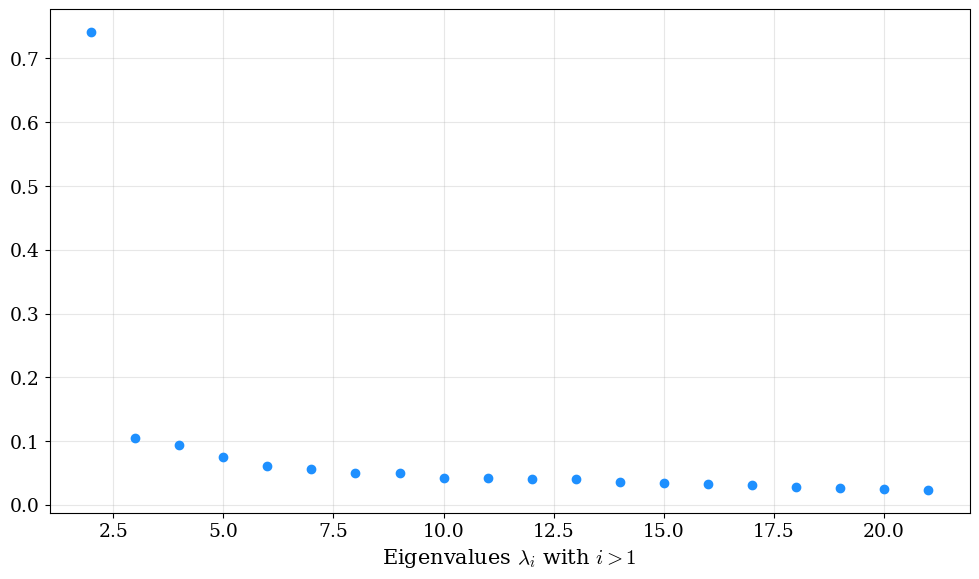

In [16]:
EV = evals[0]
plt.scatter(np.arange(2, len(EV)+1, 1), EV[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
plt.tight_layout()
plt.show()

In [ ]:
# plot_dm_parsim_coord(coord[0], g_diff_runs[0])